# Task02分享 - 艺术画笔见乾坤

学习内容：https://github.com/datawhalechina/fantastic-matplotlib

## 知识框架

本节涉及的内容非常多，这里通过思考题回顾下整体的知识框架，再用两个例子重温代码实现。

#### 1. primitives 和 container的区别和联系是什么？

Artist包含两种对象：基本要素-primitives和容器-containers。

基本要素，是不可再分的渲染单位，被存放在容器中。此外，低层次的容器可以存放在高层次的容器中。

primitives：

+ Line2D（折线）
+ Rectangle（矩形）
+ Circle（圆形）
+ Image（图像）
+ Text（文本）
+ ...

containers：
+ Figure（图像）
+ Axes（坐标系）
+ Axis（坐标轴）
+ Tick（标度）


#### 2. 四个容器的联系和区别是么？他们分别控制一张图表的哪些要素？

它们存在层次关系。`Figure`是最顶层的容器，包含很多个`Axes`以及其他零件。

一个`Axes`容器中可以包含2个或3个`Axis`，分别对应2D和3D坐标系。`Tick`又被包含在`Axis`中，有主标度和副标度。

四种容器从高到低让我们能逐步深入控制绘图的底层细节。

---

下面通过两个实例进一步回顾所学内容。

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## 题1：子图绘制

我们可以用简短的代码，将教程中常用的绘图案例打印在一张大图上。

这些方法包括：

+ line
+ errorbar
+ hist
+ bar
+ polygon
+ pie
+ scatter
+ image


In [2]:
fig = plt.figure(figsize=(18, 12))  # 创建空图

<Figure size 1296x864 with 0 Axes>

下面增加三行三列的子图，并把`Axes`做成一个数组。

`next_axes()`函数用来返回下一个`Axes`实例，为接下来的绘图提供方便。

In [3]:
axes = [fig.add_subplot(331+i) for i in range(9)]

i = -1
def next_axes(title):
    global i
    i += 1
    axes[i].set_title(title)
    return axes[i]

接着在每个`Axes`上进行作图，代码块前的注释标识出了图的类型。

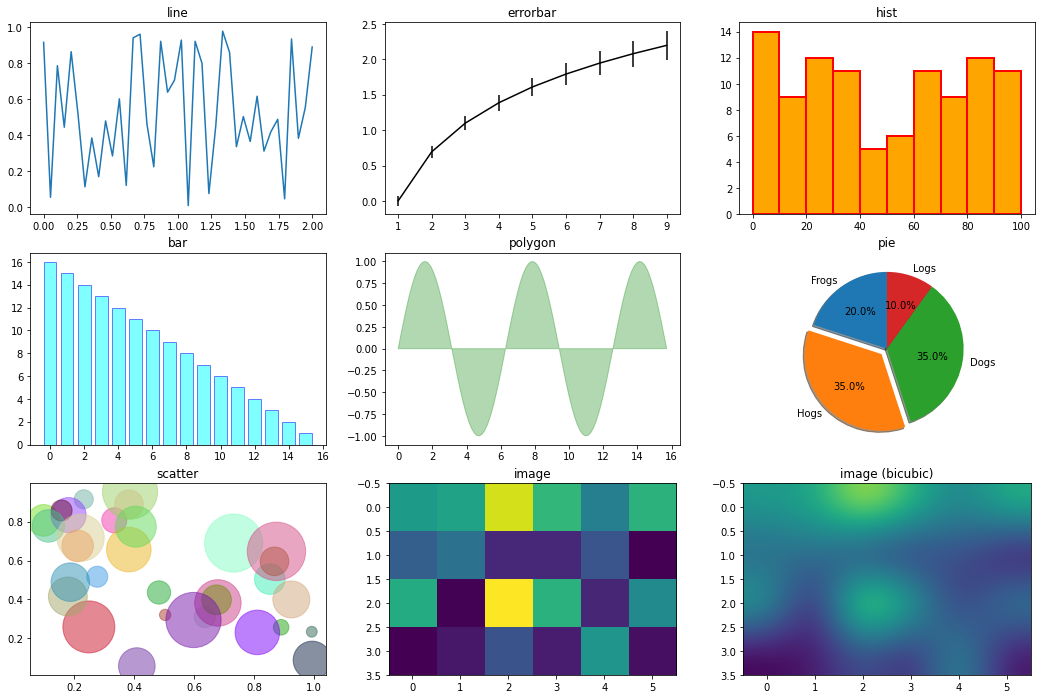

In [4]:
# line
next_axes('line').plot(np.linspace(0, 2, 40), np.random.uniform(0, 1, 40))

# errorbar
x = np.arange(10)
next_axes('errorbar').errorbar(x, np.log(x), yerr=np.linspace(0.05, 0.2, 10), c='black')

# hist
x = np.random.randint(0, 100, 100)      # 生成【0-100】之间的100个数据,即 数据集 
bins = np.arange(0, 101, 10)            # 设置连续的边界值，即直方图的分布区间[0,10], [10,20]... 
next_axes('hist').hist(x, bins, color='orange', linewidth=2, edgecolor='red')

# bar
next_axes('bar').bar(np.arange(16), range(16, 0, -1), alpha=0.5, width=0.75, color='cyan', edgecolor='blue')

# polygon
x = np.linspace(0, 5*np.pi, 100)
next_axes('polygon').fill(x, np.sin(x), color="g", alpha=0.3)

# pie
next_axes('pie').pie([20, 35, 35, 10],
        explode=(0, 0.1, 0, 0),
        labels=['Frogs', 'Hogs', 'Dogs', 'Logs' ],
        autopct='%1.1f%%',
        shadow=True,
        startangle=90
        )

# scatter
next_axes('scatter').scatter(x=np.random.rand(32), y=np.random.rand(32),
        s=np.random.uniform(10, 60, 32)**2,
        c=np.random.uniform(0, 1, [32, 3]), alpha=0.5,
        )

# image
img = np.random.rand(4, 6)
next_axes('image').imshow(img, interpolation=None, cmap='viridis')
next_axes('image (bicubic)').imshow(img, interpolation='bicubic', cmap='viridis')

fig

其实大多都是API的使用问题，熟悉整体框架之后，具体参数可以查阅官方文档，或者打印`__doc__`变量。

## 题2：绘制积分曲线

分别用一组长方形柱和填充面积的方式模仿画出下图，函数 $y = -(x - 2)(x - 8) + 10$ 在区间\[2, 9\]的积分面积

![](https://img-blog.csdnimg.cn/20201126105910781.png)
![](https://img-blog.csdnimg.cn/20201126105910780.png)

首先绘制函数图像。

先用快速的`plt.plot()`试探一下。

(0.0, 20.0)

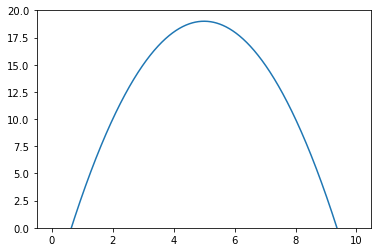

In [5]:
x = np.arange(0, 10, 0.01)
y = -1 * (x-2) * (x-8) + 10

plt.plot(x, y)
plt.ylim(0, 20)

大致轮廓有了，接着想办法绘制曲边梯形。

我们计划定义一个函数`draw_integral(axes, delta)`用于绘制积分图像，参数`axes`表示绘制的目标容器，`delta`控制划分的精细程度。

这样就能通过子图的形式，逐步精细化来展示不同`delta`下的区间划分效果。

下面先绘制一个1行3列的基本图像，等会我们再向其中添加`Artist`对象。

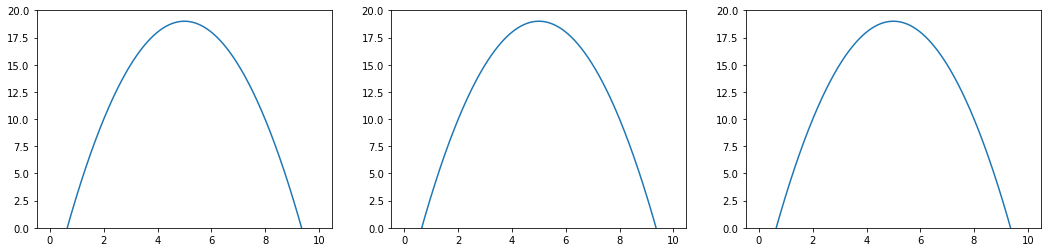

In [6]:
fig = plt.figure()
for i in range(3):
    axes_i = fig.add_subplot(1, 3, i+1)
    axes_i.plot(x, y)
    axes_i.set_ylim(0, 20)
fig.set_figwidth(fig.get_figwidth() * 3)    # 将图的宽度设置为原来的三倍

那么如何绘制曲边梯形呢，我们知道`Line2D`有一个参数是`linewidth`线宽。如果把线调粗，看起来就像小竖条了。

下面就来实现之前计划的`draw_integral()`函数，先以`delta`为步长切分x并生成y值。

对于每个小竖条，我们都建一个`Line2D`对象。它的起点是x轴上的$(x, 0)$，终点是$(x, f(x))$。

In [7]:
def draw_integral(axes, delta, linewidth=None, color=None):
    x_ = np.arange(2, 9, delta)
    y_ = -1 * (x_-2) * (x_-8) + 10

    for i in range(len(x_)):
        axes.add_line(
            plt.Line2D([x_[i], x_[i]], [0, y_[i]], linewidth=linewidth, color=color)
        )

接着，对每个`Axes`调用`draw_integral()`绘制积分图像，就能看到效果啦。

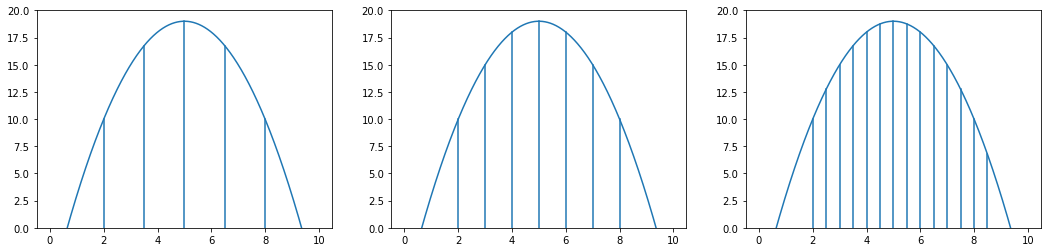

In [8]:
for i in range(3):
    draw_integral(fig.axes[i], delta=(3 - i) * 0.5)

fig

上图结果和我们预期相同，只需要把这些细线**调粗**，就变成小竖条了。

我们继续画图。在此之前，需要将每个`Axes`已有的线清除。这是因为我们每一次绘图，都是在原有的基础上添加`Artist`对象。

如果不删除这些细线，之后的绘图会叠加在这些细线上，达不到预期的效果。

### 清除画线

`Axes.get_lines()`可以获取这个`Axes`容器下的所有线实例，然后对其调用`.remove()`进行移除。

`.remove()`是`Artist`对象共有的方法，它不仅仅能移除线，对其他`Artist`对象也适用。

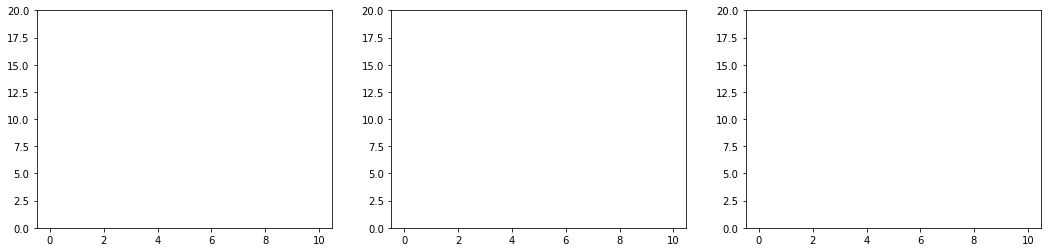

In [9]:
for i in range(3):
    for l in fig.axes[i].get_lines():
        l.remove()      # 用成员方法删除Line2D实例

fig

### 重设参数

有了上面的验证，现在我们将线宽调大来模拟小竖条的效果。

此外，减小步长以得到更精细的划分，使用浅蓝色填充让形状更加清晰。

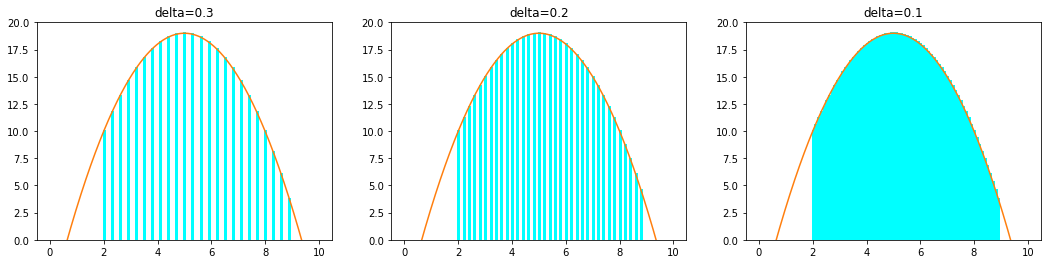

In [10]:
for i in range(3):
    delta = (3 - i) * 0.1
    draw_integral(fig.axes[i], delta=delta, linewidth=3, color='cyan')
    fig.axes[i].set_title(f'delta={round(delta, 2)}')
    fig.axes[i].plot(x, y)

fig

第三幅图还是能看见一些锯齿。

要做到完全没有锯齿，我们可以继续减小步长使图像达到更好的填充，也可以直接绘制一个填充多边形。

填充多边形的方法需要先寻找积分区间内的x，然后用`plt.fill()`进行填充。`np.where()`用于查找满足条件的索引。

注意，我们要补上x轴的两个点$(2, 0)和(9, 0)$。

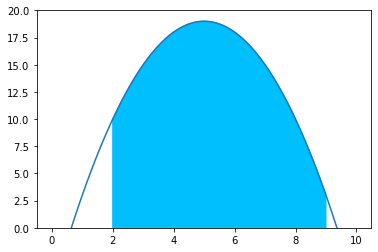

In [11]:
idx = np.where( np.logical_and(x>=2, x<=9) )[0]

plt.plot(x, y)
plt.ylim(0, 20)
plt.fill([2] + list(x[idx]) + [9], [0] + list(y[idx]) + [0], color='deepskyblue')

这样便得到了一个完美的填充。